# Semantic Similarity of Images

This notebook explores ways to compare two images. This comparison should consider the content of the image and work reasonably well even if two pictures have different lighting, angle, orientation, and so on. 

First we will try to calculate a similarity score of two images. We will see how different computational and ml models work for this task. 

After that we will implement searching of the similar images given a query image.

In [1]:
!pip install pysift

from skimage.metrics import structural_similarity as ssim
import cv2
from google.colab.patches import cv2_imshow

from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal
import numpy as np
import pandas as pd
import torch

import os
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
image_dir = './storage/images/'

# Mean Squared Error (MSE) and Structural Similarity Index (SSIM)

MSE counts the average squared difference between each corresponding pixel pair of two images.

SSIM is a perception-based model that considers image degradation as a perceived change in structural information. It is used for measuring image quality by comparing the original image with a distorted one.

In [3]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err


# Plot MSE and SSIM of two images
def compare_images(imageA, imageB, title):
	dim = (min(len(imageA), len(imageB)), min(len(imageA[0]), len(imageB[0])))
	cv2.resize(imageA, dim)
	cv2.resize(imageB, dim)
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB)
	# setup the figure
	fig = plt.figure(title)
	plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
	# show the images
	plt.show()

In [4]:
# Load the images -- the original, contrasted and cropped
original = cv2.imread(os.path.join(image_dir, '588.jpg'))
contrast = cv2.imread(os.path.join(image_dir, '592.jpg'))
cropped = cv2.imread(os.path.join(image_dir, '593.jpg'))

# convert the images to grayscale
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

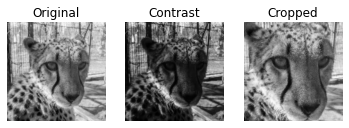

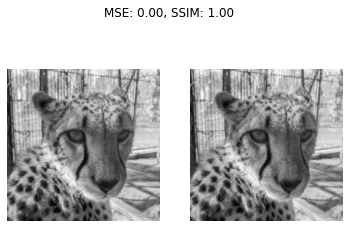

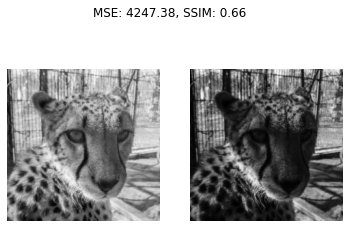

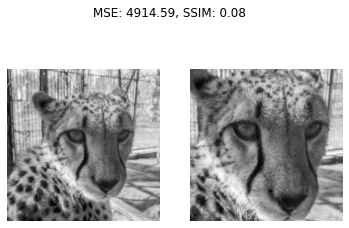

In [5]:
fig = plt.figure("Images")
images = ("Original", original), ("Contrast", contrast), ("Cropped", cropped)

# Show all images than compare each to original

for (i, (name, image)) in enumerate(images):
	ax = fig.add_subplot(1, 3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")

plt.show()

print('')
compare_images(original, original, "Original vs. Original")
print('')
compare_images(original, contrast, "Original vs. Contrast")
print('')
compare_images(original, cropped, "Original vs. Cropped")


SSIM works better for distorted images than cropped ones. MSE returned a reasonable score for both pairs.

# Scale Invariant Feature Transform (SIFT)

SIFT is a feature detection algorithm in Computer Vision. It helps locate key points in the image. These key points are scale & rotation invariant and can be used for image matching, object detection, etc. We will calculate these key points for two images, match them and define similarity in terms of the number of these matches.

In [6]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()
# detect SIFT features in both images
keypoints_1, descriptors_1 = sift.detectAndCompute(original,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(contrast,None)

In [7]:
# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# match descriptors of both images
matches = bf.match(descriptors_1,descriptors_2)

In [8]:
# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)
# draw first 50 matches
matched_img = cv2.drawMatches(original, keypoints_1, contrast, keypoints_2, matches[:50], contrast, flags=2)

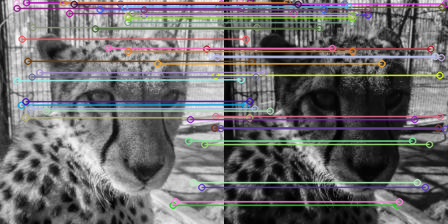

In [9]:
# show matches
cv2_imshow(matched_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


Now let's implement similarity metrics with both of these algorithms, and test searching with them.

In [10]:
# higher return value means more similarity
def similarity_ssim(imageA, imageB):
  dim = (min(len(imageA), len(imageB)), min(len(imageA[0]), len(imageB[0])))
  imageA = cv2.resize(imageA, dim)
  imageB = cv2.resize(imageB, dim)
  # m = mse(imageA, imageB)
  s = ssim(imageA, imageB)
  # return 1-m
  return s

In [11]:
# higher return value means more similarity
def similarity_sift(imageA, imageB):
  sift = cv2.xfeatures2d.SIFT_create()
  # detect SIFT features in both images
  keypoints_1, descriptors_1 = sift.detectAndCompute(imageA,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(imageB,None)
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  # match descriptors of both images
  matches = bf.match(descriptors_1,descriptors_2)
  matches = sorted(matches, key = lambda x:x.distance)
  n = 50
  return 1 - (sum([match.distance for match in matches[:n]])/n)

In [12]:
def find_similar(query_img, images, similarity, topk):
  topk = min(topk, len(images))

  similarities = [(similarity(query_img, img), i) for i, img in enumerate(images)]
  similarities.sort(key = lambda x:x[0], reverse=True)
  result_idx = [idx for sim, idx in similarities[:topk]]
  result_sim = [sim for sim, idx in similarities[:topk]]
  return result_idx, result_sim

Retrieve all images and search sample query image in them.

In [13]:
images = []
for filename in os.listdir(image_dir):
    f = os.path.join(image_dir, filename)
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)

In [14]:
query_img = cv2.imread(os.path.join(image_dir, '585.jpg'))
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

similar_images_ssim, similarity_values_ssim = find_similar(query_img, images, similarity_ssim, 5)

Functions for plotting search result.

In [15]:
def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 8)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 8)
    
    ax.set_xticks([])
    ax.set_yticks([])

def plotSimilarImages(image, simImages, simValues):
    numCol = len(simImages) + 1
    numRow = 1
    fig = plt.figure(figsize=(10, 20))
    # now plot the most similar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = image
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, '', query = True)
        else:
            img = simImages[j-1]
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], '', value = simValues[j-1]) 
        img = img.convert('RGB')
        plt.imshow(img)
    plt.show()

Query results with SSIM

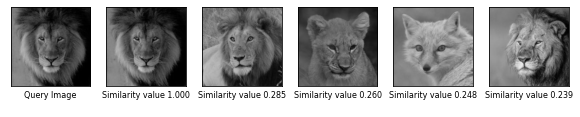

In [16]:
similar_images_ssim = [Image.fromarray(images[i]) for i in similar_images_ssim]
query_image_ssim = Image.fromarray(query_img)
plotSimilarImages(query_image_ssim, similar_images_ssim, similarity_values_ssim)

Query results with SIFT

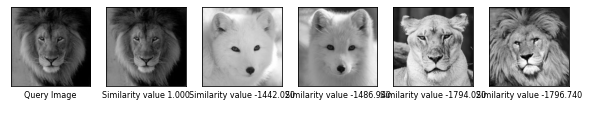

In [17]:
similar_images_sift, similarity_values_sift = find_similar(query_img, images, similarity_sift, 5)
similar_images_sift = [Image.fromarray(images[i]) for i in similar_images_sift]
query_image_sift = Image.fromarray(query_img)

plotSimilarImages(query_image_sift, similar_images_sift, similarity_values_sift)

# Resnet18

We can also use pretrained models to generate vectors for images, and use them for comparison. 

Here we use [ResNet](https://github.com/facebookarchive/fb.resnet.torch/blob/master/pretrained/README.md) which is trained on [ImageNet](https://www.image-net.org/about.php) benchmark dataset.

In [18]:
class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer

    def getVec(self, img):
          image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
          embedding = torch.zeros(1, self.numberFeatures, 1, 1)
          def copyData(m, i, o): embedding.copy_(o.data)
          h = self.featureLayer.register_forward_hook(copyData)
          self.model(image)
          h.remove()
          return embedding.numpy()[0, :, 0, 0]

First let's transform all images to vectors and store them.

In [19]:
transformationForCNNInput = transforms.Compose([transforms.Resize((224,224))])
img2vec = Img2VecResnet18()

allVectors = {}

for imageName in os.listdir(image_dir):
    I = Image.open(os.path.join(image_dir, imageName))
    I = transformationForCNNInput(I)
    vec = img2vec.getVec(I)
    allVectors[imageName] = vec

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Then we will generate a similarity matrix, so we will know the similarity score for each image pair.

In [20]:
def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    return matrix
    
similarityMatrix = getSimilarityMatrix(allVectors)

In [21]:
k=10
similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

100%|██████████| 593/593 [00:00<00:00, 1568.08it/s]


In [22]:
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
    
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))

Plot similar images for a query image.

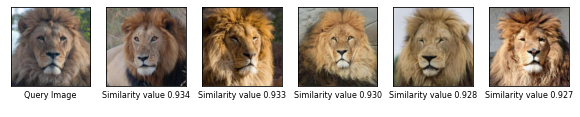

In [23]:
inputImages = ['556.jpg']
for image in inputImages:
    similar_images, similarity_values = getSimilarImages(image, similarNames, similarValues)
    similar_images = [Image.open(os.path.join(image_dir, img)) for img in similar_images[:5]]
    query_image = Image.open(os.path.join(image_dir, image))
    plotSimilarImages(query_image, similar_images, similarity_values)